**Andere manier om te kijken naar evaluation, i.p.v terug te splitten en te predicten, nu opgeslagen predicition gebruiken**

In [1]:
import pandas as pd
import torch
import os
import json
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification, Trainer
from torch.utils.data import Dataset

# === 1. Define paths ===
script_dir = os.getcwd()
project_root = os.path.dirname(script_dir)
data_folder = os.path.join(project_root, "Data")
save_path = r"C:\Users\jefva\Documents\Master\Thesis_s2\results\groNLP\Gronlp_split_lowest_val"

# === 2. Load test data ===
file_path = os.path.join(data_folder, "Test_data.xlsx")
test_df = pd.read_excel(file_path)
test_texts = test_df["clean_text"].tolist()
test_labels = test_df["theme_id"].tolist()  # ✅ Already numeric

# === 3. Load label mappings
with open(os.path.join(save_path, "label_mappings.json"), "r", encoding="utf-8") as f:
    mappings = json.load(f)

id_to_theme = {int(k): v for k, v in mappings["id_to_theme"].items()}

# === 4. Load tokenizer ===
model_name = "GroNLP/bert-base-dutch-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)

# === 5. Define dataset class ===
class ThemeDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        encoding["labels"] = torch.tensor(self.labels[idx])
        return {key: val.squeeze(0) for key, val in encoding.items()}

# === 6. Prepare dataset ===
test_dataset = ThemeDataset(test_texts, test_labels, tokenizer)

# === 7. Load model from safetensors with config ===
from transformers import BertConfig, BertForSequenceClassification

# Load the config (e.g., number of labels, architecture)
config = BertConfig.from_pretrained(save_path)

# Load model weights from .safetensors
model = BertForSequenceClassification.from_pretrained(
    save_path,
    config=config,
    use_safetensors=True
)


# === 8. Init Trainer (no compute_metrics needed for now)
trainer = Trainer(model=model, tokenizer=tokenizer)

# === 9. Predict with progress bar
preds_output = trainer.predict(test_dataset)

# === 10. Extract logits and predictions
logits = preds_output.predictions
predictions = np.argmax(logits, axis=1)

# === 11. Save output in the original format
output_df = pd.DataFrame({
    "text": test_texts,
    "true_label": test_labels,
    "predicted_label": predictions,
    "logits": logits.tolist()
})

# ✅ Save with the same name your evaluation expects
output_df.to_csv(os.path.join(save_path, "test_predictions2.csv"), index=False)


C:\Users\jefva\AppData\Local\Temp\ipykernel_14752\4196570450.py:71: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


In [2]:
import pandas as pd
import torch
import numpy as np
import torch.nn.functional as F
import os
import json  # Needed for loading the mappings


# ✅ Load the saved test predictions 
df = pd.read_csv(os.path.join(save_path, "test_predictions2.csv"))

# ✅ Recreate logits tensor from the CSV
logits = torch.tensor(df["logits"].apply(eval).tolist())

# ✅ Apply softmax to get prediction probabilities
probabilities = F.softmax(logits, dim=1)

# ✅ Extract raw values
texts = df["text"].tolist()
true_labels_ids = df["true_label"].tolist()
predicted_label_ids = df["predicted_label"].tolist()

# ✅ Convert label IDs to themes using the mappings
with open(os.path.join(save_path, "label_mappings.json"), "r", encoding="utf-8") as f:
    mappings = json.load(f)

theme_to_id = mappings["theme_to_id"]
id_to_theme = {int(k): v for k, v in mappings["id_to_theme"].items()}  # convert keys back to int
unique_themes = mappings["unique_themes"]  # Load the unique themes list


**Unknowns**

In [3]:
# ✅ Dynamic confidence threshold
confidence_values = torch.max(probabilities, dim=1)[0].tolist()
dynamic_threshold = np.percentile(confidence_values, 1)
print(f"Dynamic Threshold: {dynamic_threshold:.4f}")

# ✅ Predict with "Unknown" logic
predicted_labels = []
for i in range(len(probabilities)):
    max_prob = torch.max(probabilities[i]).item()
    pred_id = torch.argmax(probabilities[i]).item()
    question = texts[i]

    if len(question.split()) < 4:
        predicted_labels.append("Unknown")
    elif max_prob < dynamic_threshold:
        predicted_labels.append("Unknown")
    else:
        predicted_labels.append(id_to_theme[pred_id])

# ✅ Convert true labels to theme names
true_labels = [id_to_theme[i] for i in true_labels_ids]

# ✅ Compare and mark correctness
results = []
for true, pred in zip(true_labels, predicted_labels):
    if pred == "Unknown":
        results.append("Unknown")
    elif true == pred:
        results.append("Correct")
    else:
        results.append("Incorrect")

# ✅ Build output DataFrame
output_df = pd.DataFrame({
    "Text": texts,
    "True_Theme": true_labels,
    "Predicted_Theme": predicted_labels,
    "Result": results
})

# ✅ Save it
output_df.to_csv("evaluated_predictions.csv", index=False)



Dynamic Threshold: 0.1509


In [4]:
unknown_count = predicted_labels.count("Unknown")
print(f"Unknown predictions: {unknown_count} / {len(predicted_labels)} ({unknown_count/len(predicted_labels)*100:.2f}%)")


Unknown predictions: 97 / 9686 (1.00%)


**Evaluations**

C:\Users\jefva\AppData\Local\Temp\ipykernel_14752\1732032154.py:27: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jefva\anaconda3\envs\bert_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


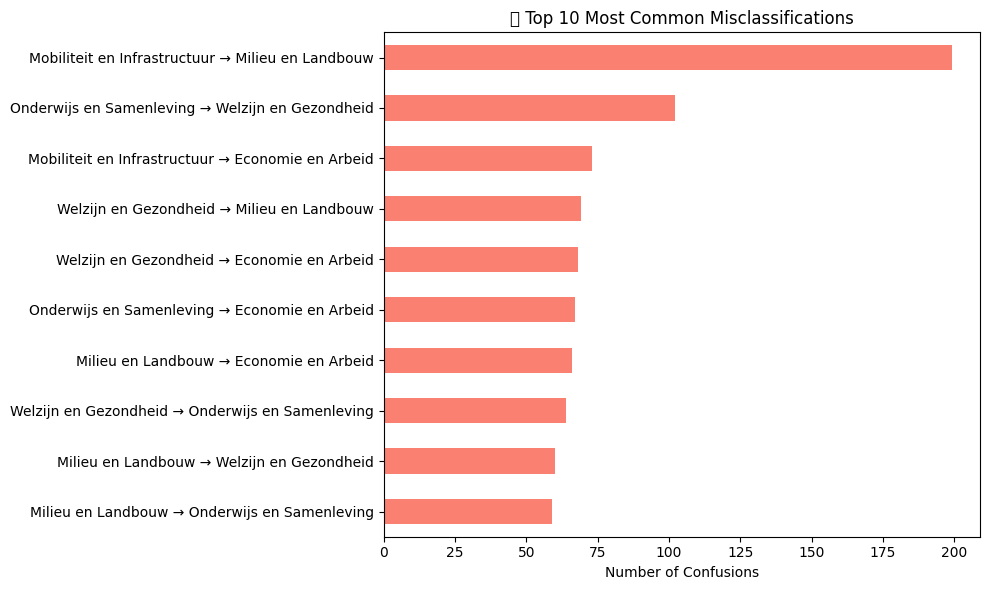

In [5]:
# ✅ Misclassification analysis (excluding Unknowns)
df_misclassified = output_df[
    (output_df["Result"] == "Incorrect") &
    (output_df["Predicted_Theme"] != "Unknown")
]

top_confusions = (
    df_misclassified
    .groupby(["True_Theme", "Predicted_Theme"])
    .size()
    .sort_values(ascending=False)
    .head(10)
)

# ✅ Convert MultiIndex to string for plotting
top_confusions_plot = top_confusions.copy()
top_confusions_plot.index = [f"{true} → {pred}" for true, pred in top_confusions_plot.index]

# ✅ Plot it
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
top_confusions_plot.plot(kind="barh", color="salmon")
plt.xlabel("Number of Confusions")
plt.title("🔍 Top 10 Most Common Misclassifications")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

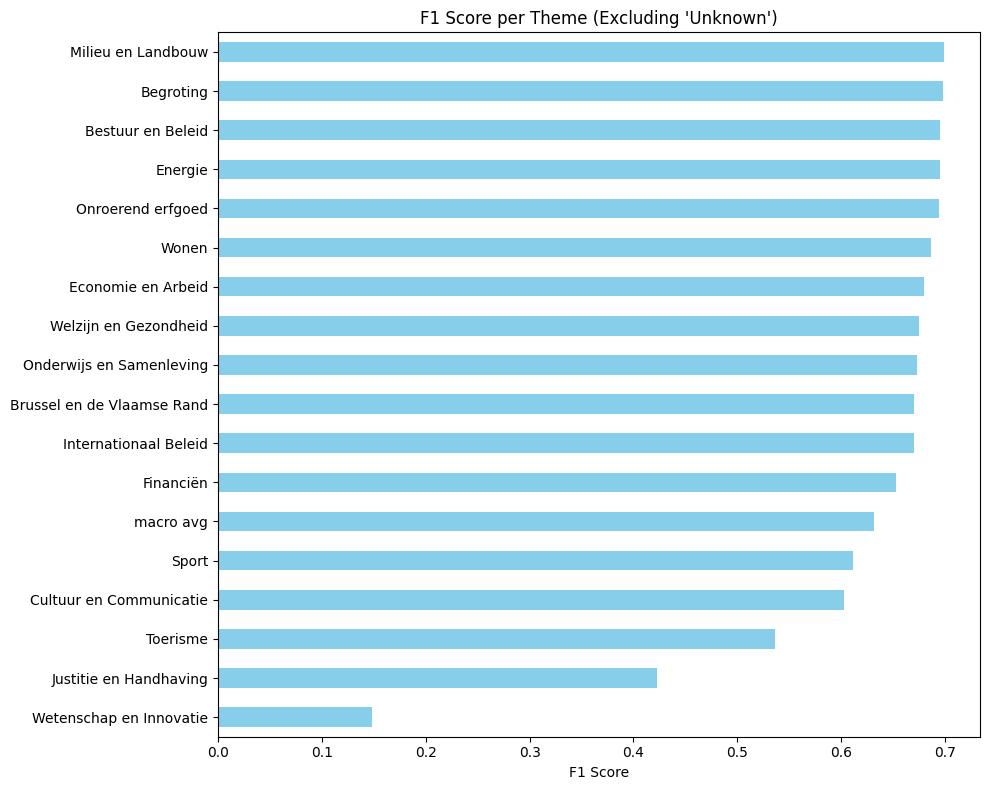

In [6]:
# for clean per-class evaluation, you want to exclude "Unknown" from both True and Predicted values:

from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# ✅ Filter out 'Unknown' predictions for proper label matching
filtered_df = output_df[output_df["Predicted_Theme"] != "Unknown"].copy()

# ✅ Encode using only the matching rows
le = LabelEncoder()
true_encoded = le.fit_transform(filtered_df["True_Theme"])
pred_encoded = le.transform(filtered_df["Predicted_Theme"])

# ✅ Get classification report
report = classification_report(
    true_encoded,
    pred_encoded,
    target_names=le.classes_,
    output_dict=True
)

# ✅ Visualize F1 per class
import pandas as pd
import matplotlib.pyplot as plt

df_report = pd.DataFrame(report).transpose().sort_values("f1-score")
df_report[:-3]["f1-score"].plot(kind="barh", figsize=(10, 8), color="skyblue")
plt.title("F1 Score per Theme (Excluding 'Unknown')")
plt.xlabel("F1 Score")
plt.tight_layout()
plt.show()

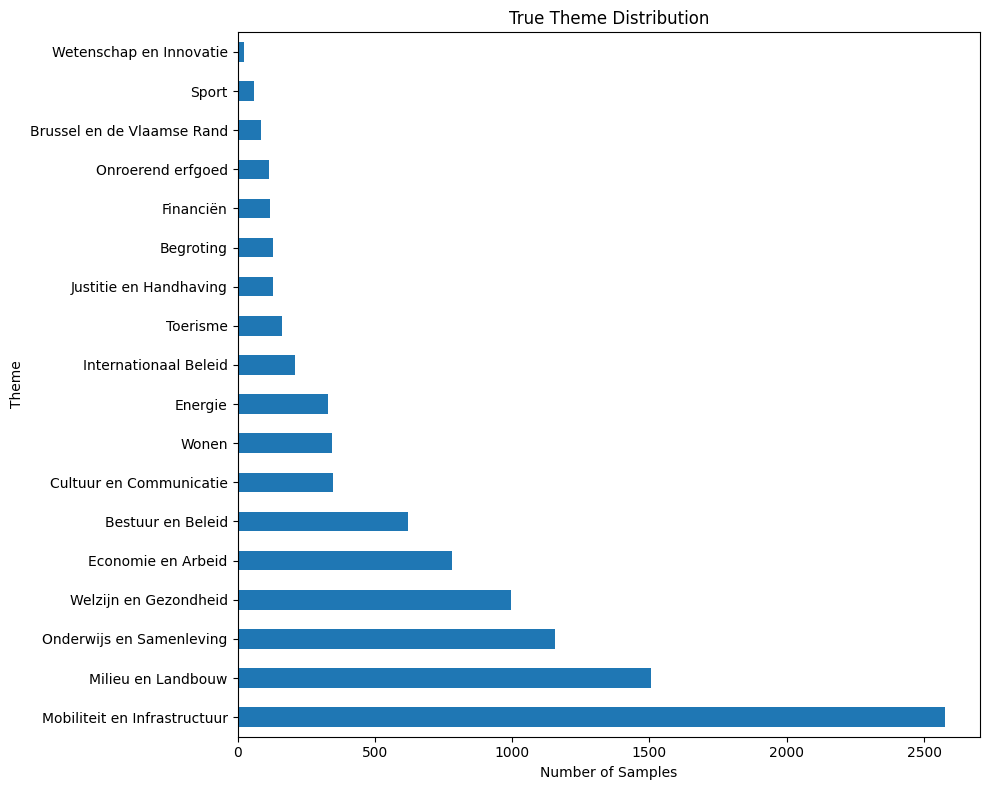

In [7]:
output_df["True_Theme"].value_counts().plot(kind="barh", figsize=(10, 8))

plt.title("True Theme Distribution")
plt.xlabel("Number of Samples")
plt.ylabel("Theme")
plt.tight_layout()
plt.show()


In [8]:
from sklearn.metrics import classification_report

# Filter out "Unknown"
filtered_true = []
filtered_pred = []
for true, pred in zip(true_labels, predicted_labels):
    if pred != "Unknown":
        filtered_true.append(true)
        filtered_pred.append(pred)

# Get all unique themes used
all_labels = sorted(set(filtered_true + filtered_pred))

# ✅ Print classification report using theme names directly
print(classification_report(
    filtered_true,
    filtered_pred,
    labels=all_labels,
    target_names=all_labels,
    zero_division=0
))


                              precision    recall  f1-score   support

                   Begroting       0.82      0.60      0.70       124
           Bestuur en Beleid       0.71      0.68      0.70       616
  Brussel en de Vlaamse Rand       0.66      0.69      0.67        83
     Cultuur en Communicatie       0.59      0.61      0.60       339
          Economie en Arbeid       0.61      0.77      0.68       774
                     Energie       0.73      0.67      0.70       328
                   Financiën       0.64      0.66      0.65       116
       Internationaal Beleid       0.72      0.62      0.67       207
      Justitie en Handhaving       0.31      0.65      0.42       127
          Milieu en Landbouw       0.66      0.74      0.70      1492
Mobiliteit en Infrastructuur       0.94      0.78      0.85      2556
    Onderwijs en Samenleving       0.68      0.67      0.67      1148
           Onroerend erfgoed       0.84      0.59      0.69       113
                   

In [9]:
# ✅ Compute metrics (excluding "Unknown")
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

filtered_true = []
filtered_pred = []
for true, pred in zip(true_labels, predicted_labels):
    if pred != "Unknown":
        filtered_true.append(true)
        filtered_pred.append(pred)

accuracy = accuracy_score(filtered_true, filtered_pred)
precision = precision_score(filtered_true, filtered_pred, average="weighted", zero_division=0)
recall = recall_score(filtered_true, filtered_pred, average="weighted", zero_division=0)
f1 = f1_score(filtered_true, filtered_pred, average="weighted", zero_division=0)

print("\n📊 Evaluation (excluding 'Unknown'):")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")


📊 Evaluation (excluding 'Unknown'):
Accuracy:  0.7130
Precision: 0.7343
Recall:    0.7130
F1-Score:  0.7184


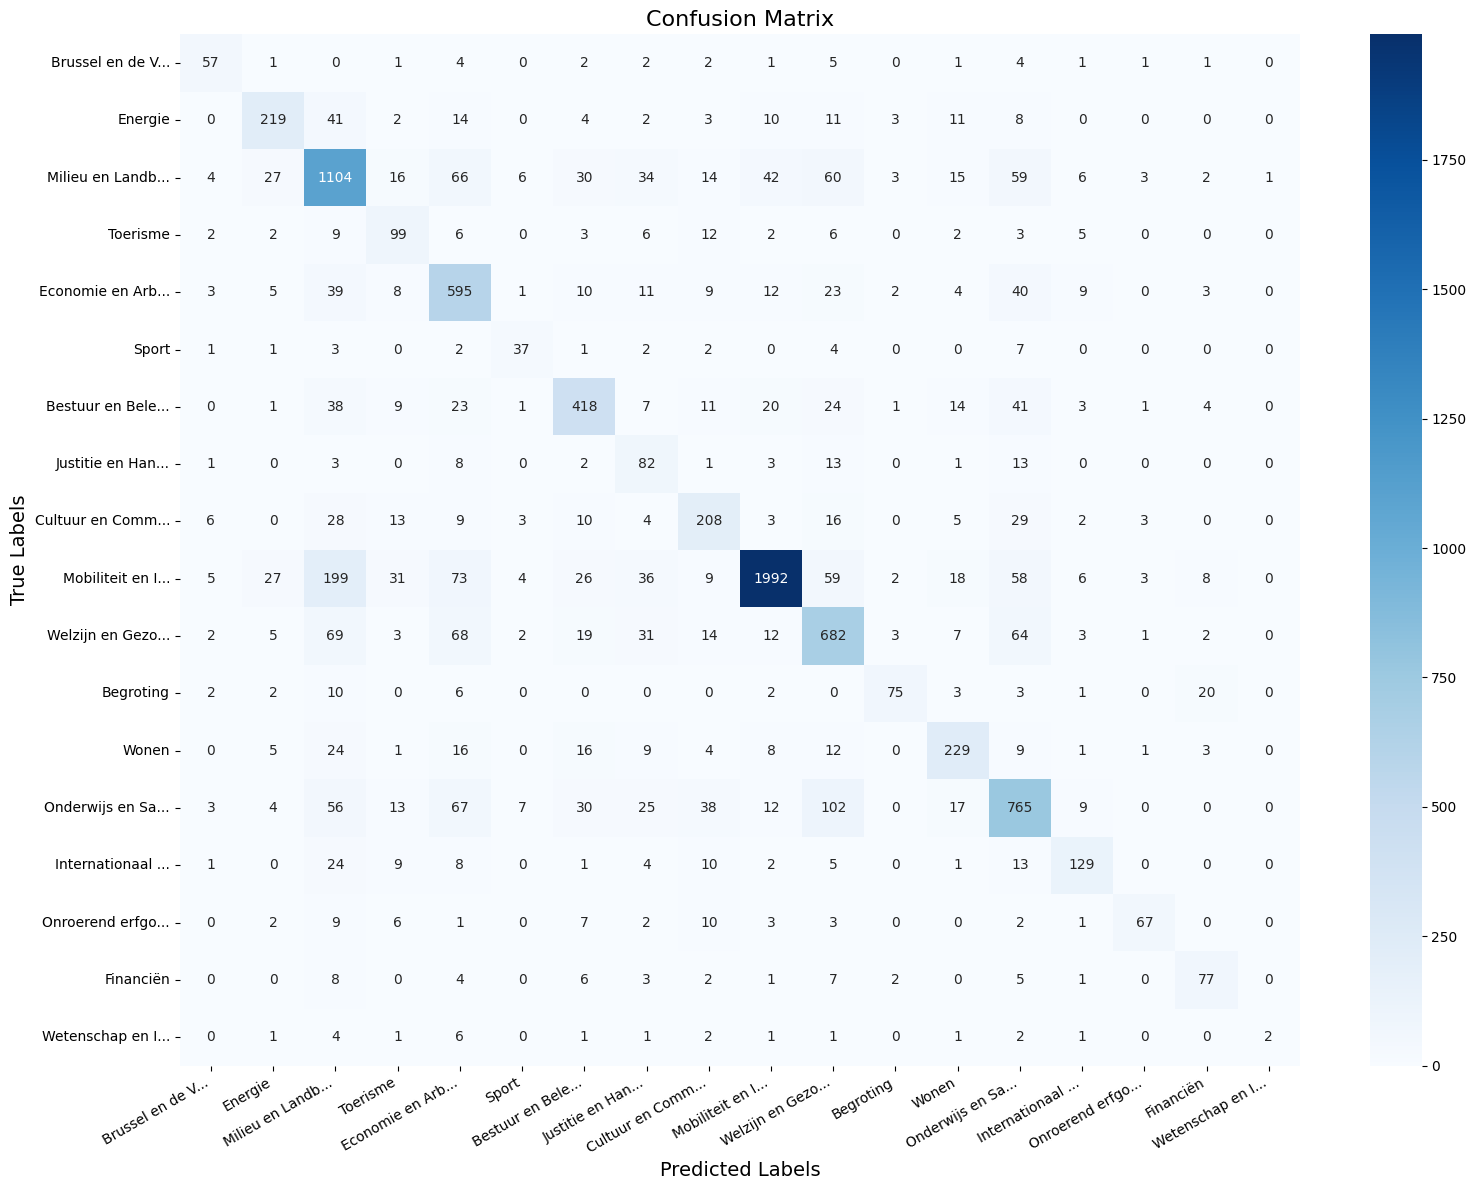

In [10]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=unique_themes)

# Shorten labels for better readability (optional)
short_labels = [label[:15] + "..." if len(label) > 15 else label for label in unique_themes]

# Plot confusion matrix as a heatmap
plt.figure(figsize=(16, 12))  # Increase figure size
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=short_labels, yticklabels=short_labels, cbar=True)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.xticks(rotation=30, ha="right", fontsize=10)  # Rotate x-axis labels slightly
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

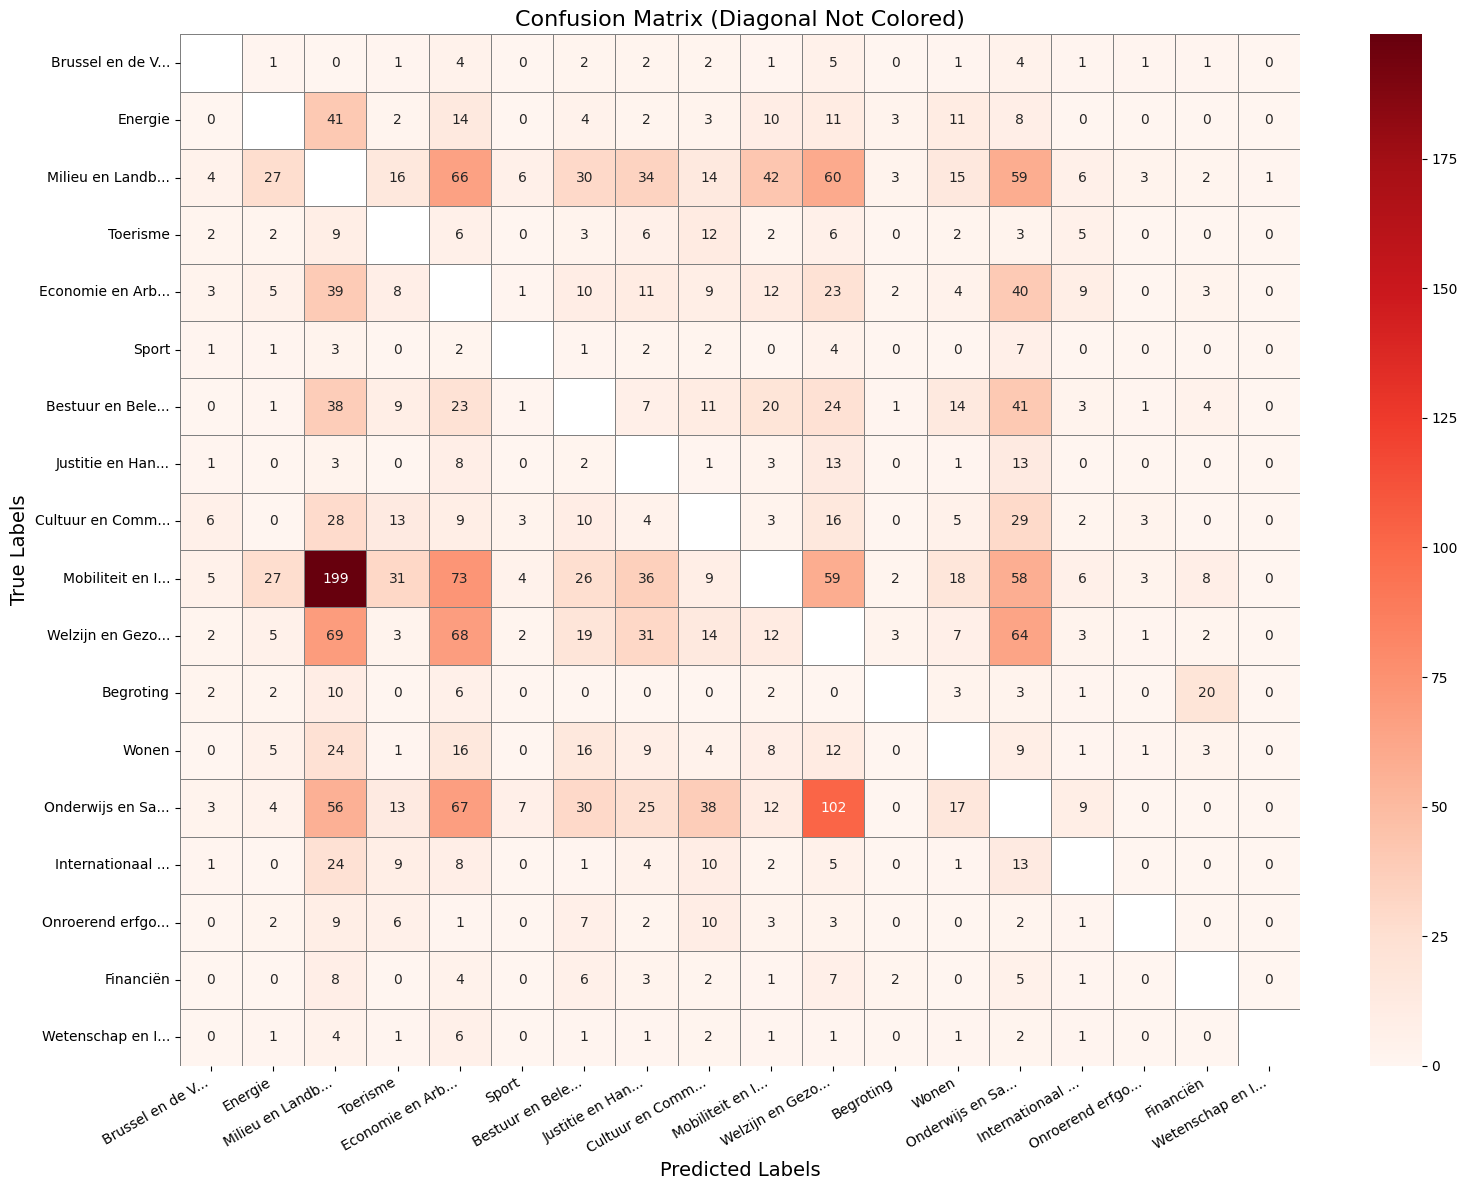

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=unique_themes)

# Shorten labels for better readability
short_labels = [label[:15] + "..." if len(label) > 15 else label for label in unique_themes]

# Create a mask for the diagonal
mask = np.eye(cm.shape[0], dtype=bool)

# Set up the figure
plt.figure(figsize=(16, 12))

# Plot the full confusion matrix, but mask the diagonal (no color there)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Reds",
    xticklabels=short_labels,
    yticklabels=short_labels,
    cbar=True,
    mask=mask,  # ✅ Do not color the diagonal
    linewidths=0.5,  # Optional: thin lines for better visibility
    linecolor='grey'
)

# Titles and labels
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.title("Confusion Matrix (Diagonal Not Colored)", fontsize=16)
plt.xticks(rotation=30, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


In [15]:
import numpy as np

# Start from your confusion matrix cm
cm = confusion_matrix(true_labels, predicted_labels, labels=unique_themes)

# Set diagonal to zero (we don't want to count correct predictions)
cm_no_diag = cm.copy()
np.fill_diagonal(cm_no_diag, 0)

# Now sum over the rows (i.e., sum each column)
wrong_predictions_per_class = cm_no_diag.sum(axis=0)

# Turn into a dictionary for easy readability
wrong_preds_dict = {label: wrong_predictions_per_class[idx] for idx, label in enumerate(unique_themes)}

# If you want sorted output (most mistakes first)
wrong_preds_sorted = dict(sorted(wrong_preds_dict.items(), key=lambda item: item[1], reverse=True))

# Print
print("Wrong predictions per predicted class:")
for label, count in wrong_preds_sorted.items():
    print(f"{label}: {count}")


Wrong predictions per predicted class:
Milieu en Landbouw: 564
Economie en Arbeid: 381
Onderwijs en Samenleving: 360
Welzijn en Gezondheid: 351
Justitie en Handhaving: 179
Bestuur en Beleid: 168
Cultuur en Communicatie: 143
Mobiliteit en Infrastructuur: 134
Toerisme: 113
Wonen: 100
Energie: 83
Internationaal Beleid: 49
Financiën: 43
Brussel en de Vlaamse Rand: 30
Sport: 24
Begroting: 16
Onroerend erfgoed: 13
Wetenschap en Innovatie: 1


In [12]:
from transformers import BertTokenizer, BertForSequenceClassification

model_path = r"C:\Users\jefva\Documents\Master\Thesis_s2\results\groNLP\GroNLP3\GroNLP3"
model_name = "GroNLP/bert-base-dutch-cased"              # aanpassen naar welk model je wilt evaluaten !!!!
tokenizer = BertTokenizer.from_pretrained(model_name) 
model = BertForSequenceClassification.from_pretrained(model_path).cuda()
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30073, 768, padding_idx=3)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
def get_attention_and_prediction(clean_text):
    """Extracts attention scores and model prediction for a given question."""
    model.config.output_attentions = True  # Ensure attention is enabled

    # Tokenize and move to device
    tokenizer_inputs = tokenizer(clean_text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    tokenizer_inputs = {key: val.to(device) for key, val in tokenizer_inputs.items()}

    # Forward pass
    with torch.no_grad():
        outputs = model(**tokenizer_inputs)

    # Extract attention and logits
    attentions = outputs.attentions
    logits = outputs.logits

    # Get predicted class ID and name
    predicted_class_id = logits.argmax(dim=1).item()
    predicted_class_name = id_to_theme.get(predicted_class_id, "Unknown")

    return attentions, predicted_class_id, predicted_class_name


In [ ]:
test_question = "Hoeveel subsidies zijn toegekend aan bedrijven?"
attention_scores, predicted_class_id, predicted_class_name = get_attention_and_prediction(test_question)

print(f"✅ Model predicted class: {predicted_class_name} (ID: {predicted_class_id})")
print(f"🔍 Total Attention Layers Extracted: {len(attention_scores)}")


In [ ]:
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Load saved predictions
df = pd.read_csv(r"C:\Users\jefva\Documents\Master\Thesis_s2\results\groNLP\GroNLP3\GroNLP3\test_predictions.csv")

# Reconstruct logits and true labels
logits = np.array(df["logits"].apply(eval).tolist())
y_true = np.array(df["true_label"].tolist())
y_score = logits  # raw logits

# Get number of classes
n_classes = y_score.shape[1]

# Binarize the true labels
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
from scipy.special import softmax
y_score = softmax(logits, axis=1)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute support (number of samples per class)
support = np.bincount(y_true, minlength=n_classes)
total = support.sum()

# Compute weighted AUC
weighted_auc = sum(roc_auc[i] * support[i] for i in range(n_classes)) / total
print(f"✅ Weighted ROC AUC: {weighted_auc:.4f}")

# Get real class names from mapping
class_names = [id_to_theme[i] for i in range(n_classes)]

# Plot ROC curves
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve (Weighted AUC = {:.2f})".format(weighted_auc))
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.preprocessing import LabelEncoder
import umap
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np


# Sample 2000 rows for UMAP
sample_df = df[["text", "true_label"]].sample(n=min(2000, len(df)), random_state=42)
sample_df.rename(columns={"text": "clean_text", "true_label": "theme_id"}, inplace=True)

# Function to get CLS embedding
def get_cls_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model.base_model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :]
    return cls_embedding.cpu().squeeze().numpy()

# Generate embeddings
embeddings = []
print("Generating fine-tuned embeddings (from test set)...")
for text in tqdm(sample_df["clean_text"]):
    emb = get_cls_embedding(text)
    embeddings.append(emb)

# Run UMAP
print("Running UMAP...")
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

# Encode labels for plotting
le = LabelEncoder()
labels = le.fit_transform(sample_df["theme_id"])

# Plot UMAP
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=labels, cmap="tab20", s=10, alpha=0.8)
plt.title("UMAP of GroNLP BERT Embeddings (After Fine-tuning)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
cb = plt.colorbar(scatter, ticks=range(len(le.classes_)), label="Theme")
tick_labels = [id_to_theme[i] for i in le.classes_]
cb.ax.set_yticklabels(tick_labels)
plt.clim(-0.5, len(le.classes_)-0.5)
plt.grid(True)
plt.tight_layout()
plt.show()